In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
transform = transforms.ToTensor()

In [13]:
train_data = datasets.MNIST(root='datasets', train=True, download=True, transform=transform)

In [14]:
test_data = datasets.MNIST(root='datasets', train=False, download=True, transform=transform)

In [15]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: datasets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [16]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: datasets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [17]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [18]:
# 1 color channel, 6 filters (output channels) 3by3 kernel, stride = 1
conv1 = nn.Conv2d(1, 6, 3, 1) # ---> 6 filters --> pooling --> conv2

# 6 Input Filters Conv1, 16 filters out, 3by3, stride=1
conv2 = nn.Conv2d(6, 16, 3, 1)

In [19]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [37]:
X_train.shape

torch.Size([1, 28, 28])

In [38]:
y_train

tensor(5)

In [22]:
x = X_train.view(1, 1, 28,28) # ---> 4D batch

In [23]:
x = F.relu(conv1(x))

In [24]:
x.shape

torch.Size([1, 6, 26, 26])

In [25]:
x = F.max_pool2d(x, 2, 2)

In [26]:
x.shape

torch.Size([1, 6, 13, 13])

In [27]:
x = F.relu(conv2(x))

In [28]:
x.shape

torch.Size([1, 16, 11, 11])

In [29]:
x = F.max_pool2d(x, 2, 2)

In [30]:
x.shape

torch.Size([1, 16, 5, 5])

In [31]:
x.view(-1, 16*5*5).shape # -1 keeps previous shape of dimension

torch.Size([1, 400])

In [32]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [33]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
import time
start_time = time.time()

# Variables (Trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#For loop epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader): #X_train = 1 x 28 x 28, y_train = label
        b+=1

        # Train
        y_pred = model(X_train) # Not flattened due to conv2D
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1] #predicted labels as a 1d tensor
        batch_corr = (predicted == y_train).sum() #if these predicted labels of 1d tensor == y_train or actual values, this ends up being 1d tensor of values then summed.
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 600 == 0:
            print(f'EPOCH: {i} BATCH: {b} LOSS: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_pred, y_train)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")



EPOCH: 0 BATCH: 600 LOSS: 0.04255055636167526
EPOCH: 0 BATCH: 1200 LOSS: 0.07605955749750137
EPOCH: 0 BATCH: 1800 LOSS: 0.36373868584632874
EPOCH: 0 BATCH: 2400 LOSS: 0.026480570435523987
EPOCH: 0 BATCH: 3000 LOSS: 0.008208819665014744
EPOCH: 0 BATCH: 3600 LOSS: 0.0015681401127949357
EPOCH: 0 BATCH: 4200 LOSS: 0.5645227432250977
EPOCH: 0 BATCH: 4800 LOSS: 0.032551269978284836
EPOCH: 0 BATCH: 5400 LOSS: 0.012761639431118965
EPOCH: 0 BATCH: 6000 LOSS: 0.03970568627119064
EPOCH: 1 BATCH: 600 LOSS: 0.003998166415840387
EPOCH: 1 BATCH: 1200 LOSS: 0.018281463533639908
EPOCH: 1 BATCH: 1800 LOSS: 0.16669586300849915
EPOCH: 1 BATCH: 2400 LOSS: 0.0995219498872757
EPOCH: 1 BATCH: 3000 LOSS: 0.00788261741399765
EPOCH: 1 BATCH: 3600 LOSS: 0.09027031064033508
EPOCH: 1 BATCH: 4200 LOSS: 0.01537509448826313
EPOCH: 1 BATCH: 4800 LOSS: 0.009246616624295712
EPOCH: 1 BATCH: 5400 LOSS: 0.02709277532994747
EPOCH: 1 BATCH: 6000 LOSS: 0.016526710242033005
EPOCH: 2 BATCH: 600 LOSS: 0.07655125856399536
EPOCH: 2

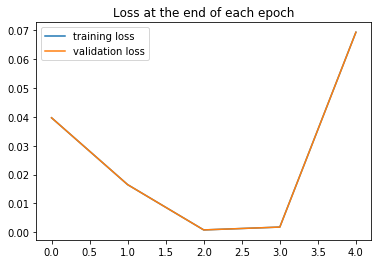

In [41]:
with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend();

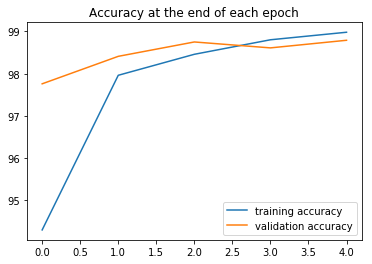

In [42]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [43]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [45]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [46]:
correct.item()/len(test_data)

0.9879

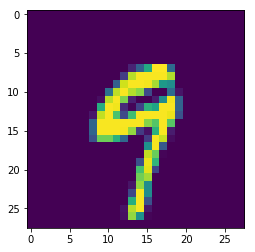

In [47]:
plt.imshow(test_data[2019][0].reshape(28, 28))

In [48]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[2019][0].view(1, 1, 28, 28))

In [49]:
new_prediction.argmax()

tensor(9)